In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split
import argparse
import datetime
import wandb
import torchvision.transforms as transforms
from einops import rearrange
from PIL import Image
import pytorch_lightning as pl

import torch.distributed as dist
from lightning_utilities.core.rank_zero import rank_zero_only

if dist.is_initialized():
    rank = dist.get_rank()
    rank_zero_only.rank = rank == 0
else:
    rank_zero_only.rank = True

from pytorch_lightning.loggers import WandbLogger
import copy

# own code
from config import Config_Generative_Model
from dataset import create_Kamitani_dataset, create_BOLD5000_dataset, create_allen_dataset
# from dc_ldm.ldm_for_spike import sLDM
from dc_ldm.ldm_for_fmri import fLDM
from eval_metrics import get_similarity_metric

In [2]:
os.environ['RANK'] = '0'
os.environ['LOCAL_RANK'] = '0'

In [3]:
pl.__version__

'1.6.5'

In [4]:
torch.FloatTensor

torch.FloatTensor

In [5]:
def wandb_init(config, output_path):
    wandb.init( project='mind-vis',
                group="stageB_dc-ldm",
                anonymous="allow",
                config=config,
                reinit=True)
    create_readme(config, output_path)

def wandb_finish():
    wandb.finish()

In [6]:
def to_image(img):
    if img.shape[-1] != 3:
        img = rearrange(img, 'c h w -> h w c')
    img = 255. * img
    return Image.fromarray(img.astype(np.uint8))

def channel_last(img):
        if img.shape[-1] == 3:
            return img
        return rearrange(img, 'c h w -> h w c')

def get_eval_metric(samples, avg=True):
    metric_list = ['mse', 'pcc', 'ssim', 'psm']
    res_list = []
    
    gt_images = [img[0] for img in samples]
    gt_images = rearrange(np.stack(gt_images), 'n c h w -> n h w c')
    samples_to_run = np.arange(1, len(samples[0])) if avg else [1]
    for m in metric_list:
        res_part = []
        for s in samples_to_run:
            pred_images = [img[s] for img in samples]
            pred_images = rearrange(np.stack(pred_images), 'n c h w -> n h w c')
            res = get_similarity_metric(pred_images, gt_images, method='pair-wise', metric_name=m)
            res_part.append(np.mean(res))
        res_list.append(np.mean(res_part))     
    res_part = []
    for s in samples_to_run:
        pred_images = [img[s] for img in samples]
        pred_images = rearrange(np.stack(pred_images), 'n c h w -> n h w c')
        res = get_similarity_metric(pred_images, gt_images, 'class', None, 
                        n_way=50, num_trials=50, top_k=1, device='cuda')
        res_part.append(np.mean(res))
    res_list.append(np.mean(res_part))
    res_list.append(np.max(res_part))
    metric_list.append('top-1-class')
    metric_list.append('top-1-class (max)')
    return res_list, metric_list

In [11]:
def generate_images(generative_model, fmri_latents_dataset_train, fmri_latents_dataset_test, config):
    grid, _ = generative_model.generate(fmri_latents_dataset_train, config.num_samples, 
                config.ddim_steps, config.HW, 10) # generate 10 instances
    grid_imgs = Image.fromarray(grid.astype(np.uint8))
    grid_imgs.save(os.path.join(config.output_path, 'samples_train.png'))
    wandb.log({'summary/samples_train': wandb.Image(grid_imgs)})

    grid, samples = generative_model.generate(fmri_latents_dataset_test, config.num_samples, 
                config.ddim_steps, config.HW)
    grid_imgs = Image.fromarray(grid.astype(np.uint8))
    grid_imgs.save(os.path.join(config.output_path,f'./samples_test.png'))
    for sp_idx, imgs in enumerate(samples):
        for copy_idx, img in enumerate(imgs[1:]):
            img = rearrange(img, 'c h w -> h w c')
            Image.fromarray(img).save(os.path.join(config.output_path, 
                            f'./test{sp_idx}-{copy_idx}.png'))

    wandb.log({f'summary/samples_test': wandb.Image(grid_imgs)})

    # metric, metric_list = get_eval_metric(samples, avg=config.eval_avg)
    # metric_dict = {f'summary/pair-wise_{k}':v for k, v in zip(metric_list[:-2], metric[:-2])}
    # metric_dict[f'summary/{metric_list[-2]}'] = metric[-2]
    # metric_dict[f'summary/{metric_list[-1]}'] = metric[-1]
    # wandb.log(metric_dict)

In [12]:
def normalize(img):
    if img.shape[-1] == 3:
        img = rearrange(img, 'h w c -> c h w')
    img = torch.tensor(img)
    img = img * 2.0 - 1.0 # to -1 ~ 1
    return img

class random_crop:
    def __init__(self, size, p):
        self.size = size
        self.p = p
    def __call__(self, img):
        if torch.rand(1) < self.p:
            return transforms.RandomCrop(size=(self.size, self.size))(img)
        return img

In [13]:
def fmri_transform(x, sparse_rate=0.2):
    # x: 1, num_voxels
    x_aug = copy.deepcopy(x)
    idx = np.random.choice(x.shape[0], int(x.shape[0]*sparse_rate), replace=False)
    x_aug[idx] = 0
    return torch.FloatTensor(x_aug)

In [14]:
def update_config(args, config):
    for attr in config.__dict__:
        if hasattr(args, attr):
            if getattr(args, attr) != None:
                setattr(config, attr, getattr(args, attr))
    return config

def create_readme(config, path):
    print(config.__dict__)
    with open(os.path.join(path, 'README.md'), 'w+') as f:
        print(config.__dict__, file=f)


def create_trainer(num_epoch, precision=32, accumulate_grad_batches=2,logger=None, check_val_every_n_epoch=0):
    acc = 'gpu' if torch.cuda.is_available() else 'cpu'
    return pl.Trainer(accelerator=acc, max_epochs=num_epoch, logger=logger, 
            precision=precision, accumulate_grad_batches=accumulate_grad_batches,
            enable_checkpointing=False, enable_model_summary=False, gradient_clip_val=0.5,
            check_val_every_n_epoch=check_val_every_n_epoch, devices=1, strategy=None)

In [15]:
config = Config_Generative_Model()

if config.checkpoint_path is not None:
    model_meta = torch.load(config.checkpoint_path, map_location='cpu')
    ckp = config.checkpoint_path
    config = model_meta['config']
    config.checkpoint_path = ckp
    print('Resuming from checkpoint: {}'.format(config.checkpoint_path))

output_path = os.path.join(config.root_path, 'results', 'generation',  '%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")))
config.output_path = output_path
os.makedirs(output_path, exist_ok=True)

In [16]:
config.num_epoch = 10

In [17]:
config.dataset

'ALLEN'

In [18]:
from pytorch_lightning.utilities import rank_zero_only
rank_zero_only.rank = 0

wandb_init(config, output_path)
logger = WandbLogger()
config.logger = logger

# project setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(config.seed)
np.random.seed(config.seed)

crop_pix = int(config.crop_ratio*config.img_size)
img_transform_train = transforms.Compose([
    normalize,
    random_crop(config.img_size-crop_pix, p=0.5),
    transforms.Resize((256, 256)), 
    channel_last
])
img_transform_test = transforms.Compose([
    normalize, transforms.Resize((256, 256)), 
    channel_last
])
if config.dataset == 'GOD':
    fmri_latents_dataset_train, fmri_latents_dataset_test = create_Kamitani_dataset(config.kam_path, config.roi, config.patch_size, 
            fmri_transform=fmri_transform, image_transform=[img_transform_train, img_transform_test], 
            subjects=config.kam_subs)
    num_voxels = fmri_latents_dataset_train.num_voxels
elif config.dataset == 'BOLD5000':
    fmri_latents_dataset_train, fmri_latents_dataset_test = create_BOLD5000_dataset(config.bold5000_path, config.patch_size, 
            fmri_transform=fmri_transform, image_transform=[img_transform_train, img_transform_test], 
            subjects=config.bold5000_subs)
    num_voxels = fmri_latents_dataset_train.num_voxels
elif config.dataset == 'ALLEN':
    fmri_latents_dataset_train, fmri_latents_dataset_test = create_allen_dataset(fmri_transform=fmri_transform, image_transform=[img_transform_train, img_transform_test])
    
    num_voxels = fmri_latents_dataset_train.n_neurons
else:
    raise NotImplementedError

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zhaizhongyuan (11785-bhiksha). Use `wandb login --relogin` to force relogin


{'seed': 2022, 'root_path': '../', 'kam_path': '../data/Kamitani/npz', 'bold5000_path': '../data/BOLD5000', 'allen_path': '../data/ALLEN', 'roi': 'VC', 'patch_size': 8, 'pretrain_gm_path': '../pretrains/ldm/label2img', 'dataset': 'ALLEN', 'kam_subs': ['sbj_3'], 'bold5000_subs': ['CSI1'], 'pretrain_mbm_path': '../pretrains/ALLEN/fmri_encoder.pth', 'img_size': 256, 'batch_size': 25, 'lr': 5.3e-05, 'num_epoch': 10, 'precision': 32, 'accumulate_grad': 1, 'crop_ratio': 0.2, 'global_pool': False, 'use_time_cond': True, 'eval_avg': True, 'num_samples': 5, 'ddim_steps': 250, 'HW': None, 'model_meta': None, 'checkpoint_path': None, 'output_path': '../results/generation/04-12-2024-21-39-37'}


/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [19]:
fmri_latents_dataset_train[0]['fmri'].shape

/scratch/1012665/ipykernel_2099985/2336139990.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


torch.Size([1, 896])

In [20]:
fmri_latents_dataset_train[0]['image'].shape

/scratch/1012665/ipykernel_2099985/2336139990.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


torch.Size([256, 256, 3])

/scratch/1012665/ipykernel_2099985/2336139990.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


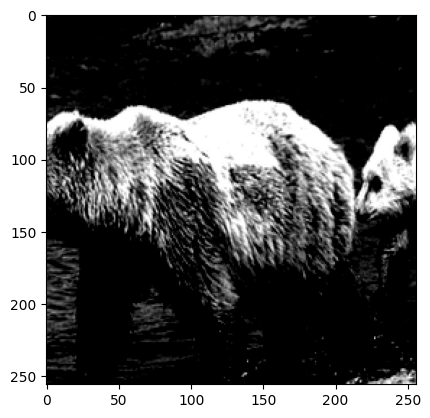

In [21]:
plt.imshow(fmri_latents_dataset_train[0]['image'].numpy())

In [22]:
# prepare pretrained mbm 
# pretrain_mbm_metafile = torch.load(config.pretrain_mbm_path, map_location='cpu', weights_only=False)
pretrain_mbm_metafile = torch.load(config.pretrain_mbm_path, map_location='cpu')
# create generateive model
generative_model = fLDM(pretrain_mbm_metafile, num_voxels,
            device=device, pretrain_root=config.pretrain_gm_path, logger=config.logger, 
            ddim_steps=config.ddim_steps, global_pool=config.global_pool, use_time_cond=config.use_time_cond)

# # resume training if applicable
if config.checkpoint_path is not None:
    model_meta = torch.load(config.checkpoint_path, map_location='cpu')
    generative_model.model.load_state_dict(model_meta['model_state_dict'])
    print('model resumed')

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 401.32 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
missing keys: []
unexpected keys: ['mask_token']


In [23]:
config.batch_size

25

In [24]:
# finetune the model
trainer = create_trainer(config.num_epoch, config.precision, config.accumulate_grad, logger, check_val_every_n_epoch=5)
generative_model.finetune(trainer, fmri_latents_dataset_train, fmri_latents_dataset_test,
            config.batch_size, config.lr, config.output_path, config=config)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:326: LightningDeprecationWarning: Base `LightningModule.on_train_batch_start` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(



##### Stage One: only optimize conditional encoders #####


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LatentDiffusion: Only optimizing conditioner params!


/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/torch/optim/adamw.py:91: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(AdamW, self).__init__(params, defaults)


Sanity Checking: 0it [00:00, ?it/s]

/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/scratch/1012665/ipykernel_2099985/2336139990.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:17<00:00, 14.06it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.93it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.93it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.93it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.94it/s]
/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hice1/zzhai37/.conda/envs/mind-vis/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:16<00:00, 14.83it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.91it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.87it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.72it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.72it/s]


Validation: 0it [00:00, ?it/s]

rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:16<00:00, 14.81it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.93it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.90it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.72it/s]


rendering 3 examples in 250 steps.
Data shape for PLMS sampling is (3, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
































































































































PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 15.71it/s]


In [ ]:
# generate images
# generate limited train images and generate images for subjects seperately
generate_images(generative_model, fmri_latents_dataset_train, fmri_latents_dataset_test, config)
wandb_finish()

/scratch/1006450/ipykernel_767274/2336139990.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img)


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.06it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 19.99it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.02it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.07it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.09it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.25it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.21it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:23<00:00, 10.64it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.30it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.28it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.24it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.23it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.22it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.09it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.10it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.10it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.11it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:13<00:00, 19.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:13<00:00, 18.07it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.10it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.10it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:13<00:00, 18.40it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.12it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 19.85it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.09it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 19.88it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:15<00:00, 16.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:13<00:00, 18.00it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 19.92it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.14it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.13it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.20it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.19it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.16it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.15it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.17it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps


PLMS Sampler: 100%|██████████| 250/250 [00:12<00:00, 20.18it/s]


rendering 5 examples in 250 steps.
Data shape for PLMS sampling is (5, 3, 64, 64)
Running PLMS Sampling with 250 timesteps
